In [10]:
from pathlib import Path
from IPython.display import display
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, accuracy_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import interpret
from interpret.glassbox import ExplainableBoostingClassifier
interpret.set_visualize_provider(interpret.provider.InlineProvider())

from nam.data import NAMDataset
from nam.config import defaults
from nam.data import FoldedDataset
from nam.models import NAM
from nam.models import get_num_units
from nam.trainer import LitNAM
from nam.types import Config
from nam.utils import parse_args
from nam.utils import plot_mean_feature_importance
from nam.utils import plot_nams
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint


/Users/janik/Library/Python/3.9/lib/python/site-packages/nam/trainer/trainer.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [418]:
read_data = False
if read_data:
    all_data = pd.read_excel('All_Data.xlsx', sheet_name=None)
    all_data

array([[<Axes: title={'center': 'non_perf'}>]], dtype=object)

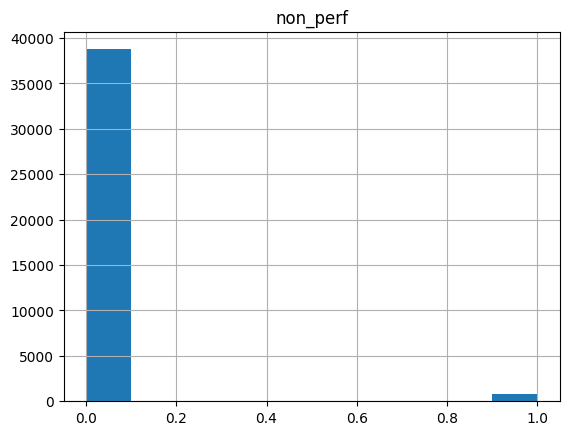

In [419]:
#Non-Perorming: A dummy variable equal to one if a loan becomes non performing at any point from April 2020 to April 2021. A loan is non-perfomring if it has missed a payment, is in the process of foreclosure, is real estate owned, or has been placed into special servicing.
cmbs_main = all_data['CMBSMainDataFile.dta']
cmbs_main[
    [
        'non_perf', 
        #'non_perf2',
    ]
].hist()


array([[<Axes: title={'center': 'Distress'}>]], dtype=object)

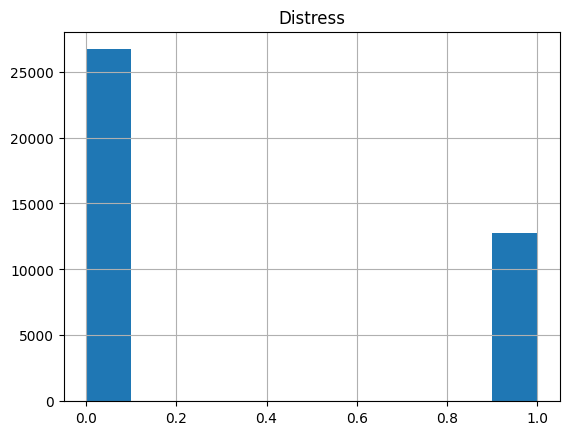

In [420]:
# Distress: A variable equal to one if a loan appears on a servicer's watchlist or becomes non-perfomring from April 2020 to April 2021. From variables AprilWatch, MayWatch, JuneWatch, JulyWatch, Augwatch, Sepwatch, Oct20Watch, Nov20Watch, Dec20Watch, Jan21Watch, Feb21Watch, Mar21Watch, Apr21Watch
cmbs_main = all_data['CMBSMainDataFile.dta']
distress = cmbs_main[['Distress']]
cmbs_main[
    [
        'Distress', 
    ]
].hist()


In [421]:
# EDA
additional_columns = [
    'Originator',
    'ApprValUSD',
    'CapRate',
    'log_bal',
    'LTV',
    'DSCR',
    'Size',
    'RateType',
    'buildingage',
    'NOI',
    'Occupancy',
] 
# age
# Rate type
# cmbs_main.columns.tolist()

In [424]:
data = cmbs_main[
    [
        'OVER_w',
        'past_over',
        #'high_overstatement2',
        'Distress',
        'non_perf'
    ] + additional_columns
]
data = data.replace(' ', pd.NA)

In [453]:
target_col = 'non_perf'

In [425]:
data['RateType']

0        Fixed
1        Fixed
2        Fixed
3        LIBOR
4        LIBOR
         ...  
39517    Fixed
39518    LIBOR
39519    Fixed
39520    Fixed
39521    Fixed
Name: RateType, Length: 39522, dtype: object

In [426]:
# Encode categorical data
data['Originator'] = LabelEncoder().fit_transform(data['Originator'])
data['RateType'] = LabelEncoder().fit_transform(data['RateType'])

In [427]:
clean_data = data[
    data.notna().all(axis=1)
]
clean_data

,OVER_w,past_over,Distress,non_perf,Originator,ApprValUSD,CapRate,log_bal,LTV,DSCR,Size,RateType,buildingage,NOI,Occupancy
0,-0.317393,0.186364,1.0,0.0,129,13240000.0,0.061237,17.073606,0.354,2.119,16485.000000,1,2.890372,234100.0,0.94
5,-0.008745,0.168498,0.0,0.0,65,40200000.0,0.087664,15.907374,0.718,3.691,18149.000000,1,2.772589,1216909.0,0.95
6,0.086101,0.418182,0.0,0.0,12,1540000.0,0.045671,14.659230,0.343,1.630,983.862976,2,3.465736,2192208.0,0.95
9,0.023822,0.445026,0.0,0.0,114,23630000.0,0.054455,15.736249,0.727,1.750,19000.000000,2,3.332205,384367.0,0.98
10,-0.356910,0.328042,0.0,0.0,131,3150000.0,0.062622,14.950776,0.677,1.601,23234.000000,1,2.639057,1740917.0,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39516,0.198225,0.285861,0.0,0.0,58,12300000.0,0.050276,19.113829,0.713,1.956,20185.000000,1,0.693147,18215154.0,0.79
39517,-0.273799,0.112903,1.0,0.0,70,39000000.0,0.050974,16.183134,0.552,1.396,5844.137207,1,3.496508,919807.0,0.98
39519,-0.179458,0.117834,0.0,0.0,22,82500000.0,0.066112,16.404778,0.650,2.100,1861.412964,1,3.583519,1089638.0,0.91
39520,0.100647,0.255241,1.0,0.0,55,5250000.0,0.047434,15.571125,0.647,1.190,3760.346924,1,3.044523,221662.0,0.98


In [428]:
clean_data = clean_data.astype({'Occupancy': float})

In [429]:
# Percentage of clean data from whole dataset
len(clean_data) / len(data)

0.7145640402813623

In [430]:
target = clean_data[target_col]
X = clean_data.drop(columns=target_col)

In [431]:
sample_size = len(target) 
sample_size

28241

In [432]:
X_train, X_test, y_train, y_test = train_test_split(X.head(sample_size), target.head(sample_size), random_state=42)

In [433]:
X_train_oversampled, y_train_oversampled = SMOTE().fit_resample(X_train, y_train)

array([[<Axes: title={'center': 'OVER_w'}>,
        <Axes: title={'center': 'past_over'}>,
        <Axes: title={'center': 'Distress'}>,
        <Axes: title={'center': 'Originator'}>],
       [<Axes: title={'center': 'ApprValUSD'}>,
        <Axes: title={'center': 'CapRate'}>,
        <Axes: title={'center': 'log_bal'}>,
        <Axes: title={'center': 'LTV'}>],
       [<Axes: title={'center': 'DSCR'}>,
        <Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'RateType'}>,
        <Axes: title={'center': 'buildingage'}>],
       [<Axes: title={'center': 'NOI'}>,
        <Axes: title={'center': 'Occupancy'}>, <Axes: >, <Axes: >]],
      dtype=object)

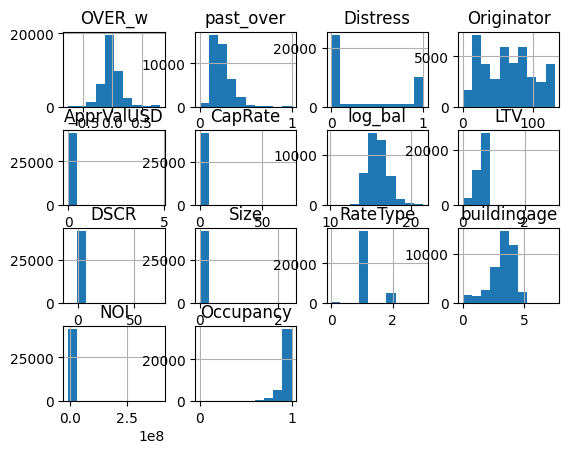

In [434]:
X_train_oversampled.hist()

<Axes: >

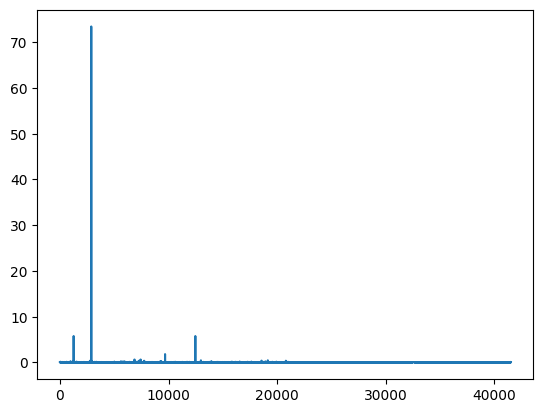

In [435]:
X_train_oversampled['CapRate'].plot()

<Axes: >

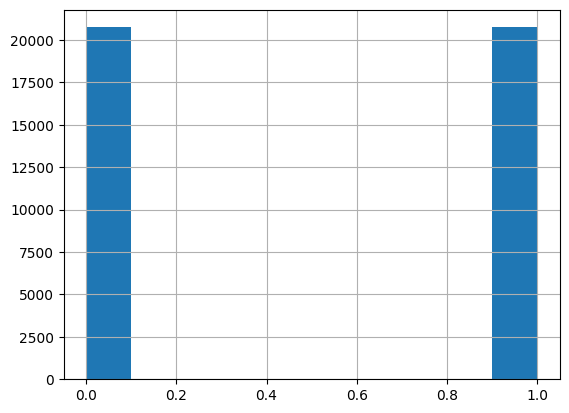

In [436]:
y_train_oversampled.hist()

array([[<Axes: title={'center': 'OVER_w'}>,
        <Axes: title={'center': 'past_over'}>,
        <Axes: title={'center': 'Distress'}>,
        <Axes: title={'center': 'Originator'}>],
       [<Axes: title={'center': 'ApprValUSD'}>,
        <Axes: title={'center': 'CapRate'}>,
        <Axes: title={'center': 'log_bal'}>,
        <Axes: title={'center': 'LTV'}>],
       [<Axes: title={'center': 'DSCR'}>,
        <Axes: title={'center': 'Size'}>,
        <Axes: title={'center': 'RateType'}>,
        <Axes: title={'center': 'buildingage'}>],
       [<Axes: title={'center': 'NOI'}>,
        <Axes: title={'center': 'Occupancy'}>, <Axes: >, <Axes: >]],
      dtype=object)

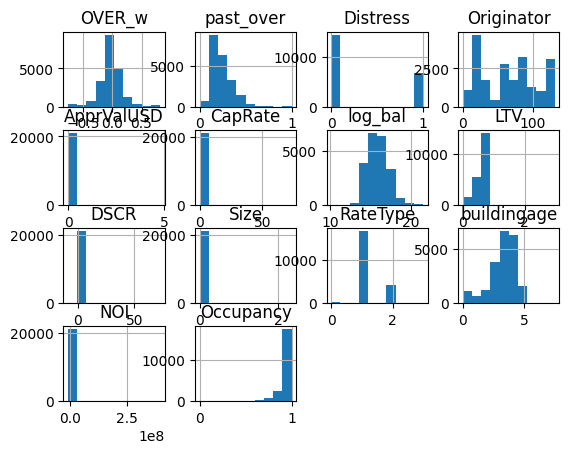

In [437]:
X_train.hist()

## Training of models

### EBM

In [438]:
# Explainable Boosting Machine
ebm = ExplainableBoostingClassifier()

ebm.fit(X_train_oversampled, y_train_oversampled)


ExplainableBoostingClassifier()

### Logisitic Regression

In [ ]:
# Logisitc Regression or XGBoost

### NAM

In [11]:
x = np.random.normal(0,2, (500,4))
clean_data = pd.DataFrame(x, columns= ['a', 'b', 'c', 'd'])
target_col = 'a'
clean_data

,a,b,c,d
0,0.856429,-1.687874,3.457416,1.111355
1,-1.798300,0.926177,-0.490615,-0.616048
2,0.114466,2.243533,2.366785,-0.143780
3,0.035130,1.689747,1.228694,0.430533
4,0.758226,2.535469,1.495948,-2.172991
...,...,...,...,...
495,0.729089,-0.984625,-0.019990,-2.932692
496,-0.296244,-2.548708,1.469587,0.979760
497,-1.982923,2.466288,-2.083433,-2.412085
498,0.514214,-1.510945,0.467439,-1.138556


In [25]:
config

namespace(device='cpu',
          seed=2021,
          data_path='data/GALLUP.csv',
          experiment_name='NAM',
          regression=False,
          num_epochs=1,
          lr=0.0003,
          batch_size=1024,
          logdir='output',
          wandb=True,
          hidden_sizes=[64, 32],
          activation='exu',
          optimizer='adam',
          dropout=0.5,
          feature_dropout=0.5,
          decay_rate=0.995,
          l2_regularization=0.5,
          output_regularization=0.5,
          num_basis_functions=1000,
          units_multiplier=2,
          shuffle=True,
          cross_val=False,
          num_folds=5,
          num_splits=3,
          fold_num=1,
          num_models=1,
          num_workers=16,
          save_model_frequency=2,
          save_top_k=3,
          use_dnn=False,
          early_stopping_patience=50)

In [13]:
# Neural Additive Model
config = defaults()
feature_cols = [col for col in clean_data.columns if col != target_col]
nam_dataset = NAMDataset(
    config,
    data_path=clean_data,
    features_columns=feature_cols,
    targets_column=target_col,
)

In [14]:
nam_model = NAM(
    config=config,
    name='Testing_NAM',
    num_inputs=len(nam_dataset[0][0]),
    num_units=get_num_units(config, nam_dataset.features)
)
nam_model

/Users/janik/Library/Python/3.9/lib/python/site-packages/torch/nn/init.py:176: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b)


NAM(
  (dropout): Dropout(p=0.5, inplace=False)
  (feature_nns): ModuleList(
    (0-2): 3 x FeatureNN(
      (dropout): Dropout(p=0.5, inplace=False)
      (model): ModuleList(
        (0): ExU(in_features=1, out_features=1000)
        (1): LinReLU(in_features=1000, out_features=64)
        (2): LinReLU(in_features=64, out_features=32)
        (3): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)

In [18]:
# NAM Training
data_loaders = nam_dataset.train_dataloaders()
for fold, (train_loader, val_loader) in enumerate(data_loaders):
     tb_logger = TensorBoardLogger(
          save_dir=config.logdir,
          name=f'{nam_model.name}',
          version=f'fold_{fold + 1}')

     checkpoint_callback = ModelCheckpoint(
          filename=tb_logger.log_dir + "/{epoch:02d}-{val_loss:.4f}",
          monitor='val_loss',
          save_top_k=config.save_top_k,
          mode='min'
     )
     litmodel = LitNAM(config, nam_model)
     pl.Trainer()
     trainer = pl.Trainer(
          logger=tb_logger,
          max_epochs=config.num_epochs,
          callbacks=checkpoint_callback,
     )
     trainer.fit(
          litmodel,
          train_dataloaders=train_loader,
          val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type | Params
-------------------------------
0 | model | NAM  | 204 K 
-------------------------------
204 K     Trainable params
0         Non-trainable params
204 K     Total params
0.818     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/janik/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/janik/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/janik/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it, v_num=ld_1, train_loss_step=227.0, Accuracy_metric_step=1.000, val_loss_step=-29.4, val_loss_epoch=-29.4, Accuracy_metric_epoch=0.475, train_loss_epoch=227.0]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, v_num=ld_1, train_loss_step=227.0, Accuracy_metric_step=1.000, val_loss_step=-29.4, val_loss_epoch=-29.4, Accuracy_metric_epoch=0.475, train_loss_epoch=227.0]


In [29]:
trainer.logger.experiment.summary

AttributeError: 'SummaryWriter' object has no attribute 'summary'

### NAM Testing and Evaluation

In [22]:
trainer.test(litmodel, dataloaders=nam_dataset.test_dataloaders())

/Users/janik/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  Accuracy_metric_epoch             1.0
     test_loss_epoch         33.93817138671875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 33.93817138671875, 'Accuracy_metric_epoch': 1.0}]

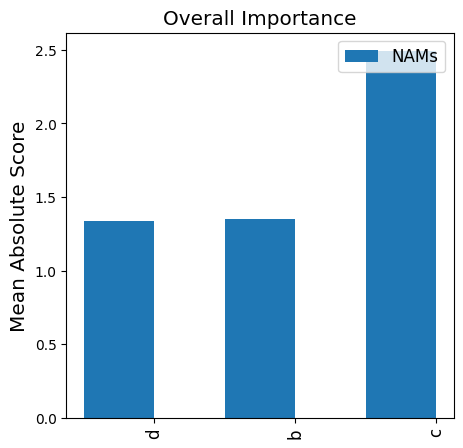

In [23]:
fig = plot_mean_feature_importance(litmodel.model, nam_dataset)

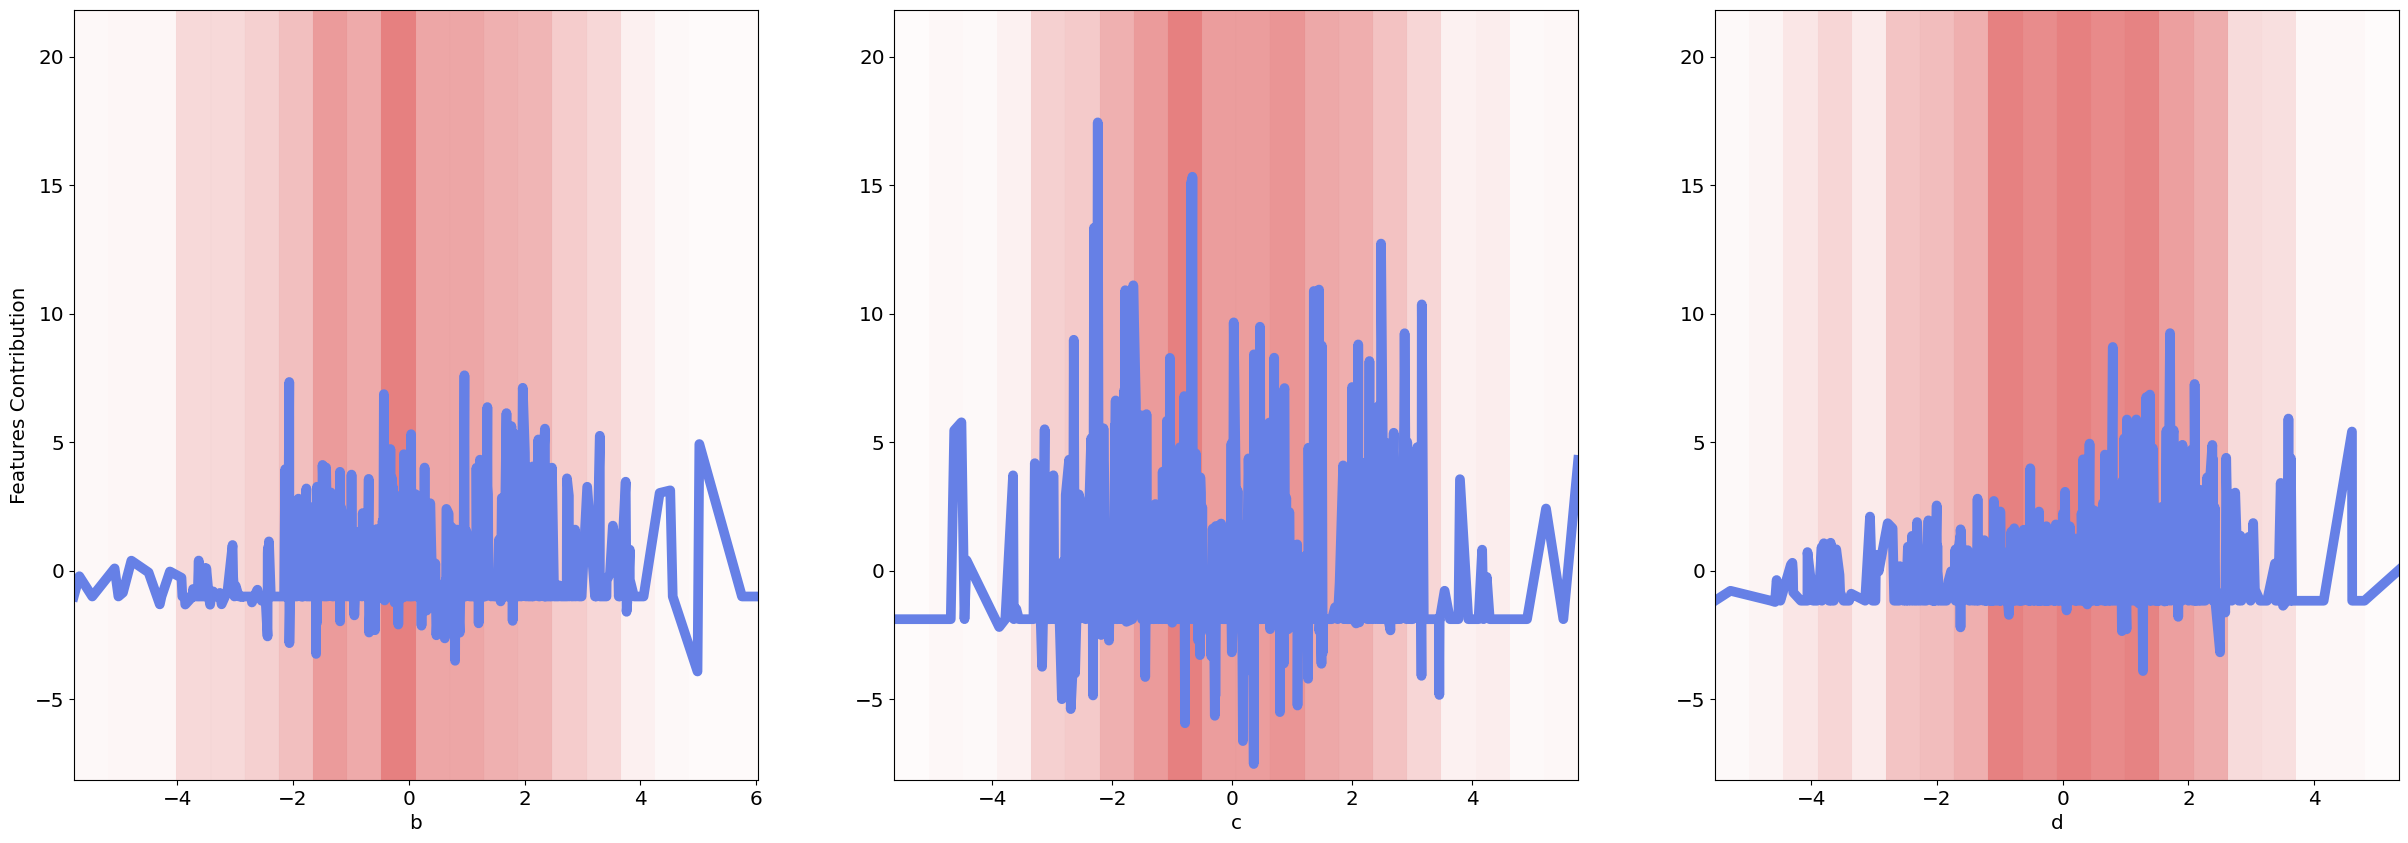

In [24]:
fig = plot_nams(litmodel.model, nam_dataset, num_cols= 3)

# Evaluation

In [439]:
y_pred = ebm.predict(X_test).astype(float)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

(array([7036.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          25.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

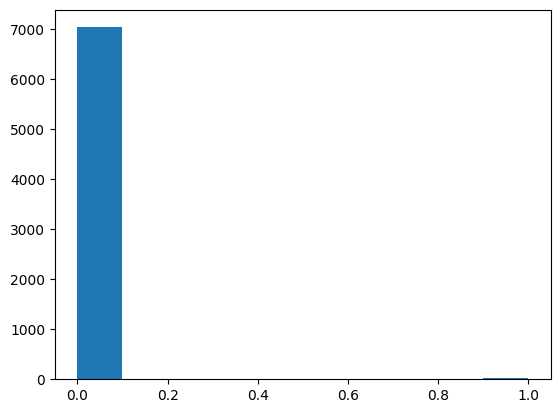

In [440]:
plt.hist(y_pred)

In [441]:
interpret.show(ebm.explain_global())

In [442]:
confusion_matrix(y_true=y_test.values, y_pred=y_pred)

array([[6905,   25],
       [ 131,    0]])

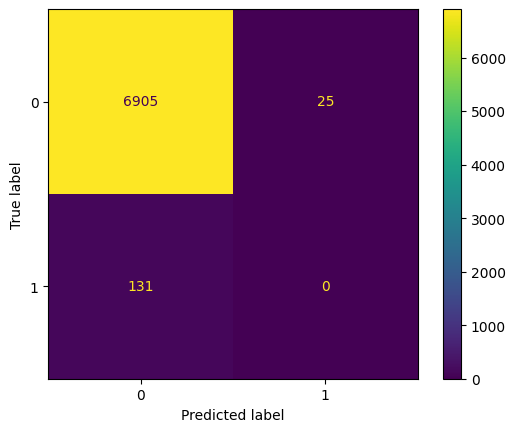

In [443]:
cm = confusion_matrix(y_true=y_test.values, y_pred=y_pred )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [444]:
# class imbalance
n_positives = len(y_train[y_train == 1.0])
n_negatives = len(y_train[y_train == 0.0])
ratio = n_positives / (n_positives + n_negatives)
print(f'Ratio of samples is: {1-ratio}')


# Calculate Scores
acc_score = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print(f'Accuracy score: {acc_score}')
print(f'ROC AUC score: {auc_roc}')


Ratio of samples is: 0.979886685552408
Accuracy score: 0.9779068120662796
ROC AUC score: 0.5034885386030424


## Anhang

from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
param_test = {'learning_rate': [0.001,0.005,0.01,0.03],
              'interactions': [5,10,15],
              'max_interaction_bins': [10,15,20],
              'max_rounds': [5000,10000,15000,20000],
              'min_samples_leaf': [2,3,5],
              'max_leaves': [3,5,10]}
n_HP_points_to_test=10
LGBM_clf = LGBMClassifier(random_state=314, n_jobs=-1)
LGBM_gs = RandomizedSearchCV(
    estimator=LGBM_clf,
    param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring="roc_auc",
    cv=3,
    refit=True,
    random_state=314,
    verbose=False,
)
LGBM_gs.fit(X_train, y_train)

for df_name, df in all_data.items():
    display(df_name)
    display(df.columns.to_list())
    display('------------')

def get_scores(clf, X_test, y_true, print_results=False):
    scores = {}
    y_pred = clf.predict(X_test)
    scores['accuracy'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    scores['recall'] = recall_score(y_true=y_true, y_pred=y_pred)
    scores['roc_auc'] = roc_auc_score(y_true=y_true, y_score=clf.predict_proba(X_test))

    if print_results:
        for score_name, score in scores.items():
            print(f'{score_name}: {score}')

    return scores